In [1]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
import os
from pathlib import Path
from datetime import datetime
from rdkit.Chem import AllChem
from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator
from rdkit import RDLogger
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import math
RDLogger.DisableLog('rdApp.warning')

In [2]:
# --- Configuration & Versioning ---
DATA_VERSION = "v1.2"
TIMESTAMP = datetime.now().strftime("%Y%m%d_%H%M")
BASE_DIR = Path(r"C:\Users\User\Desktop\spark_airflow\chembl\dags\data")
INPUT_FILE = BASE_DIR / "dataset_full_processed.parquet"
OUTPUT_DIR = BASE_DIR / "gold" / f"version_{DATA_VERSION}_{TIMESTAMP}"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# MLflow Setup
mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment("ChEMBL_EDA_Preprocessing")

pl.Config.set_tbl_cols(50)
pl.Config.set_tbl_width_chars(5000)

polars.config.Config

In [3]:
# INSPECTION FUNCTIONS
def inspect_basic_stats(df: pl.DataFrame):
    print(f"Shape: {df.shape}")
    print(df.glimpse())
    print("-" * 30)
    print("Descriptive Stats:")
    print(df.describe())

def check_missing_values(df: pl.DataFrame):
    null_counts = df.null_count()
    cols_with_nulls = [col for col in df.columns if null_counts[col][0] > 0]
    if cols_with_nulls:
        print("Missing Values:")
        print(null_counts.select(cols_with_nulls))
    else:
        print("No missing values found.")
    print("-" * 30)

def plot_missing_values(df: pl.DataFrame):
    null_counts_df = df.null_count().to_pandas()
    null_counts = null_counts_df.melt(var_name="column", value_name="n_nulls")
    null_counts["percent"] = (null_counts["n_nulls"] / df.height) * 100
    null_counts = null_counts[null_counts["n_nulls"] > 0].sort_values("percent", ascending=False)
    
    if not null_counts.empty:
        plt.figure(figsize=(10, 5))
        sns.barplot(x="percent", y="column", data=null_counts, palette="Reds_r")
        plt.title("Missing Values (%)")
        plt.show()

Shape: (24344, 48)
Rows: 24344
Columns: 48
$ action_type                      <struct[3]> null, null, null, null, null, null, null, null, null, null
$ activity_comment                       <str> null, null, null, null, null, null, null, null, null, null
$ activity_id                            <i64> 32260, 32263, 32265, 32267, 32270, 32272, 32680, 32770, 32772, 32780
$ activity_properties       <list[struct[12]]> [], [], [], [], [], [], [], [], [], []
$ assay_chembl_id                        <str> 'CHEMBL674637', 'CHEMBL621151', 'CHEMBL615325', 'CHEMBL674637', 'CHEMBL621151', 'CHEMBL615325', 'CHEMBL677833', 'CHEMBL674643', 'CHEMBL674643', 'CHEMBL674643'
$ assay_description                      <str> 'Inhibitory activity towards tyrosine phosphorylation for the epidermal growth factor-receptor kinase', 'Inhibition of autophosphorylation of human epidermal growth factor-receptor (EGF-R) expressed in A431 cells', 'Inhibition of ligand-induced proliferation in human EGF-R Kinase expressin

C:\Users\User\AppData\Local\Temp\ipykernel_8676\698661514.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="percent", y="column", data=null_counts, palette="Reds_r")


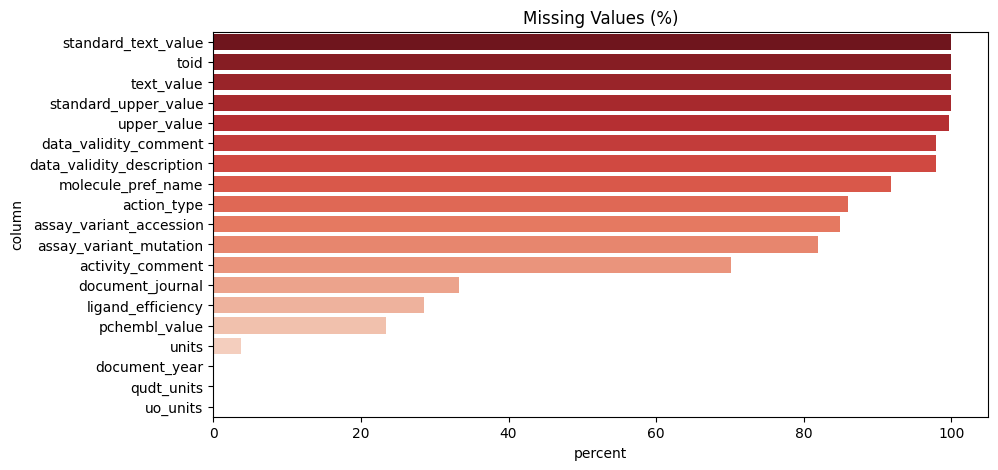

In [4]:
df_raw = pl.read_parquet(INPUT_FILE)
inspect_basic_stats(df_raw)
check_missing_values(df_raw)
plot_missing_values(df_raw)

In [5]:
# TRANSFORMATION FUNCTIONS

def unpack_struct_columns(df: pl.DataFrame) -> pl.DataFrame:
    """Expands struct columns into individual columns (Polars native unnesting)."""
    struct_cols = [col for col, dtype in zip(df.columns, df.dtypes) if isinstance(dtype, pl.Struct)]
    if not struct_cols:
        return df
    
    for col in struct_cols:
        print(f"-> Unnesting struct: {col}")
        df = df.unnest(col)
    return df

def convert_to_numeric(df: pl.DataFrame) -> pl.DataFrame:
    for col in df.columns:
        if df[col].dtype == pl.Utf8:
            attempt = df[col].cast(pl.Float64, strict=False)
            if attempt.null_count() < df.height:
                df = df.with_columns(attempt.alias(col))
    return df

def encode_one_hot(df: pl.DataFrame, max_cardinality=15) -> pl.DataFrame:
    """Performs One-Hot Encoding for low-cardinality string columns."""
    cat_cols = [col for col, dtype in zip(df.columns, df.dtypes) 
                if dtype == pl.Utf8 and df[col].n_unique() <= max_cardinality]
    
    if cat_cols:
        print(f"-> Encoding One-Hot: {cat_cols}")
        df = df.to_dummies(columns=cat_cols)
    return df

def ECFP_from_smiles(smiles, 
                     R = 2, 
                     L = 1024, 
                     use_features = False, 
                     use_chirality = False):
    
    if smiles is None or not isinstance(smiles, str):
        return [0] * L
        
    molecule = Chem.MolFromSmiles(smiles)
    
    if molecule is None:
        return [0] * L

    feature_list = AllChem.GetMorganFingerprintAsBitVect(
        molecule,
        radius = R,
        nBits = L,
        useFeatures = use_features,
        useChirality = use_chirality
    )
    
    return list(feature_list)

In [6]:
df = df_raw.filter(pl.col("standard_relation") == "=")
print(f"-> Filtered relation (=): Kept {df.height} of {df_raw.height} rows.")

df.null_count()
print(df["standard_units"].value_counts())

df = df_raw.filter(pl.col("standard_units") == "nM")

-> Filtered relation (=): Kept 18968 of 24344 rows.
shape: (4, 2)
┌────────────────┬───────┐
│ standard_units ┆ count │
│ ---            ┆ ---   │
│ str            ┆ u32   │
╞════════════════╪═══════╡
│ ug.mL-1        ┆ 64    │
│ /uM            ┆ 6     │
│ nM             ┆ 18897 │
│ 10^3 uM        ┆ 1     │
└────────────────┴───────┘


In [7]:
# Structure Unpacking & Deduplication
df = unpack_struct_columns(df)
pre_dedup = df.height
df = df.unique()
print(f"Number of duplicates: {pre_dedup - df.height} ")

# Numeric Cleaning & Encoding
df = convert_to_numeric(df)
df = encode_one_hot(df)
df = df.with_columns(
    pl.col("canonical_smiles")
    .map_elements(lambda x: ECFP_from_smiles(x), return_dtype=pl.List(pl.Int64))
    .alias("ecfp_smiles")
)
inspect_basic_stats(df)

-> Unnesting struct: action_type
-> Unnesting struct: ligand_efficiency
-> Unnesting struct: molecule_properties
Number of duplicates: 0 
-> Encoding One-Hot: ['action_type', 'description', 'parent_type', 'assay_type', 'assay_variant_accession', 'assay_variant_mutation', 'bao_endpoint', 'bao_format', 'bao_label', 'data_validity_comment', 'data_validity_description', 'qudt_units', 'relation', 'standard_relation', 'standard_text_value', 'standard_type', 'standard_units', 'target_chembl_id', 'target_organism', 'target_pref_name', 'text_value', 'type', 'uo_units', 'ro3_pass']
Shape: (24249, 121)
Rows: 24249
Columns: 121
$ action_type_INHIBITOR                                            <u8> 0, 0, 0, 1, 1, 0, 0, 0, 0, 0
$ action_type_null                                                 <u8> 1, 1, 1, 0, 0, 1, 1, 1, 1, 1
$ description_Negatively effects (inhibits) the nor…               <u8> 0, 0, 0, 1, 1, 0, 0, 0, 0, 0
$ description_null                                                 <u8> 1

In [8]:
def identify_low_info_columns(
    df: pl.DataFrame, 
    cardinality_threshold: float = 0.99, 
    null_threshold: float = 0.9,
    protected_cols: list[str] = ["canonical_smiles", "molecule_chembl_id", "standard_units"]
) -> list[str]:
    
    stats = df.select([
        pl.all().n_unique().name.suffix("_n_unique"),
        pl.all().null_count().name.suffix("_nulls")
    ])
    
    n_rows = df.height
    useless = []

    for col in df.columns:
        n_unique = stats.get_column(f"{col}_n_unique")[0]
        null_count = stats.get_column(f"{col}_nulls")[0]
        dtype = df[col].dtype
        
        # Constant variance
        if n_unique <= 1:
            useless.append(col)
            continue

        # High cardinality
        if dtype == pl.Utf8 and col not in protected_cols:
            if n_unique > n_rows * cardinality_threshold:
                useless.append(col)
                continue

        # Missing data
        if (null_count / n_rows) > null_threshold:
            useless.append(col)

    return useless


In [9]:
low_info_columns = identify_low_info_columns(df)
df = df.drop(low_info_columns)
df.shape

(24249, 105)

In [10]:
cols_to_keep = {
        "molecule_chembl_id", 
        "canonical_smiles", 
        "standard_value", 
        "standard_units",
        "mw_freebase", 
        "alogp", 
        "hba", 
        "hbd", 
        "psa", 
        "rtb", 
        "aromatic_rings", 
        "heavy_atoms", 
        "qed_weighted",
        "ecfp_smiles"
    }

cols = list(cols_to_keep.intersection(set(df.columns)))
df = df.select(cols)
df

canonical_smiles,heavy_atoms,ecfp_smiles,aromatic_rings,hbd,molecule_chembl_id,mw_freebase,hba,alogp,standard_value,psa,qed_weighted,rtb
str,i64,list[i64],i64,i64,str,f64,i64,f64,f64,f64,f64,i64
"""Cn1c(=O)c(S(=O)(=O)c2ccc(F)cc2…",33,"[0, 0, … 0]",5,2,"""CHEMBL3745885""",467.46,7,3.66,10000.0,109.74,0.39,4
"""Cn1ccc2c([C@H](Nc3cc(C#N)c4ncc…",45,"[0, 1, … 0]",4,4,"""CHEMBL5898177""",609.69,10,5.41,1.0,133.83,0.21,8
"""CC(C)(C)CNc1c(C#N)cnc2c(Cl)cc(…",41,"[0, 1, … 0]",4,4,"""CHEMBL5968112""",573.12,8,6.83,7.0,100.93,0.18,8
"""CN(C)CCCCOc1cc2ncnc(Nc3ccc(F)c…",40,"[0, 0, … 0]",4,2,"""CHEMBL4777353""",570.98,8,6.19,3.8,122.52,0.12,11
"""C/C=C/C(=O)Nc1cc(Nc2ncc(Cl)c(N…",38,"[0, 0, … 0]",3,2,"""CHEMBL5075204""",556.14,9,5.02,352.8,85.86,0.34,10
…,…,…,…,…,…,…,…,…,…,…,…,…
"""C=CC(=O)N1C[C@@H]2C[C@H]1CN2C(…",36,"[0, 0, … 0]",3,1,"""CHEMBL5186362""",532.36,7,4.8,0.3,96.89,0.37,5
"""C=CC(=O)Nc1cc(Nc2ncc(C(=O)OC(C…",45,"[0, 1, … 0]",4,2,"""CHEMBL5290929""",611.75,10,5.61,100.0,113.85,0.17,11
"""COc1cc2ncnc(Oc3ccc(NC(=O)Nc4cc…",33,"[0, 0, … 0]",4,2,"""CHEMBL3628806""",529.78,6,6.5,10000.0,94.6,0.3,6


Shape: (24249, 13)
Rows: 24249
Columns: 13
$ canonical_smiles         <str> 'Cn1c(=O)c(S(=O)(=O)c2ccc(F)cc2F)cc2cnc(Nc3ccc4[nH]ccc4c3)nc21', 'Cn1ccc2c([C@H](Nc3cc(C#N)c4ncc(C#N)c(NCC(C)(C)C)c4c3)C3=CN(C4(C(F)F)CC4)NN3)cccc2c1=O', 'CC(C)(C)CNc1c(C#N)cnc2c(Cl)cc(N[C@H](C3=CN(C(C)(C)CF)NN3)c3cccc4ncccc34)cc12', 'CN(C)CCCCOc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1NC(=O)c1cc([N+](=O)[O-])ccc1F', 'C/C=C/C(=O)Nc1cc(Nc2ncc(Cl)c(N3CCc4sccc4C3)n2)c(OC)cc1N(C)CCN(C)C', 'O=C(OCCC12C[C@H]3C[C@@H](C1)C[C@@H](C2)C3)c1cc(NCc2cc(O)ccc2O)ccc1O', 'O=C1CCC(N2C(=O)c3cccc(NCCOCCOCCOCCOCCOCCOCCCc4cccc5c4C(=O)N(C(C(=O)Nc4nccs4)c4cc(F)ccc4O)C5)c3C2=O)C(=O)N1', 'CCC(=O)Nc1ccc2c(c1)N(Cc1ccccc1)C(=O)c1cc(-c3ccc4[nH]ccc4c3)ccc1N2', 'COC(=O)c1cc(NCc2ccccc2O)ccc1O', 'C#Cc1cccc(Nc2ncnc3cc(OCCOC(=O)c4ccccc4OC(C)=O)c(OCCOC)cc23)c1'
$ heavy_atoms              <i64> 33, 45, 41, 40, 38, 32, 68, 37, 20, 40
$ ecfp_smiles        <list[i64]> [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 

C:\Users\User\AppData\Local\Temp\ipykernel_8676\698661514.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="percent", y="column", data=null_counts, palette="Reds_r")


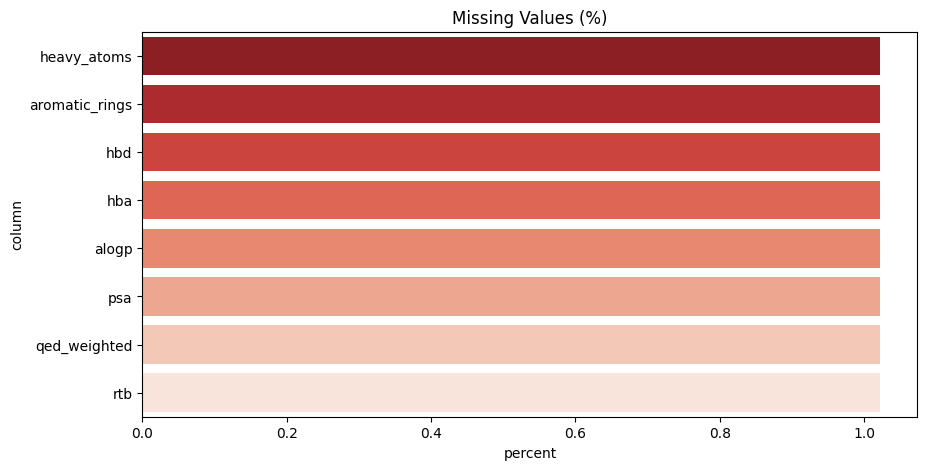

In [11]:
inspect_basic_stats(df)
check_missing_values(df)
plot_missing_values(df)

Rows before aggregation: 24249
Rows after aggregation (Unique Molecules): 13286
Shape: (13286, 13)
Rows: 13286
Columns: 13
$ molecule_chembl_id       <str> 'CHEMBL6036819', 'CHEMBL5921970', 'CHEMBL1945647', 'CHEMBL6057717', 'CHEMBL1683955', 'CHEMBL3907764', 'CHEMBL464014', 'CHEMBL6062944', 'CHEMBL63469', 'CHEMBL5532112'
$ pIC50                    <f64> 8.221848749616356, 7.301029995663981, 4.823330067331851, 5.353871964321762, 7.769551078621726, 7.301029995663981, 5.0, 6.259637310505757, 8.183541168274413, 7.552841968657781
$ canonical_smiles         <str> 'N#Cc1cnc2c(Cl)cc(N[C@H](C3=CNNN3)c3ccc(F)nc3)cc2c1Nc1cnc(F)c(F)c1', 'COc1cc2c(Nc3ccc(Cl)c(Cl)c3)ncnc2cc1OCc1noc(COCc2ccccc2)n1', 'Cc1ccc(S(=O)(=O)NC(=O)c2ccc(C)nc2Cl)cc1', 'Cc1ncsc1-c1ccc(CNC(=O)[C@@H]2C[C@@H](O)CN2C(=O)[C@H](C(C)C)N2Cc3ccccc3C2=O)c(OCCOCCOCCOCC#Cc2cccc3c2C(=O)N([C@@H](C(=O)Nc2nccs2)c2cc(F)ccc2O)C3)c1', 'Cc1ncnc(Nc2ccc(OCc3cccc(F)c3)c(Cl)c2)c1C', 'COc1cc2c(Nc3ccc(Cl)c(Cl)c3)ncnc2cc1OCCN1CCCCC1', 'CNc1cc(Nc2ccc(-c3nc

C:\Users\User\AppData\Local\Temp\ipykernel_8676\698661514.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="percent", y="column", data=null_counts, palette="Reds_r")


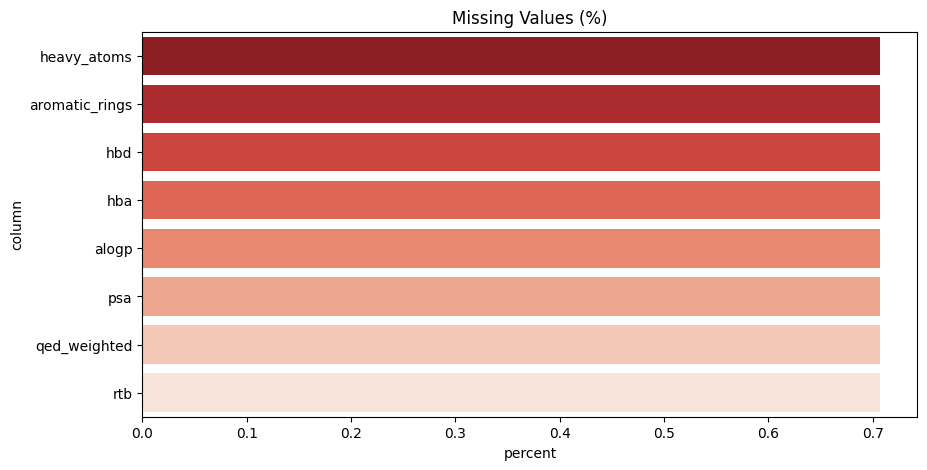

In [12]:
df = df.with_columns(pl.col("standard_value").cast(pl.Float64))
df = df.filter(pl.col("standard_value") > 0)
df = df.with_columns(
        (9 - pl.col("standard_value").log10()).alias("pIC50")
    )
    

print(f"Rows before aggregation: {df.height}")

# Define aggregation expressions dynamically
group_col = "molecule_chembl_id"
exclude_cols = {group_col, "pIC50", "standard_value", "standard_units"}
static_cols = [c for c in df.columns if c not in exclude_cols]

agg_exprs = [pl.col("pIC50").median()] + [pl.col(c).first() for c in static_cols]


df = df.group_by(group_col).agg(agg_exprs)

print(f"Rows after aggregation (Unique Molecules): {df.height}")

inspect_basic_stats(df)
check_missing_values(df)
plot_missing_values(df)

In [13]:
# ANALYSIS & VISUALIZATION

def impute_iterative_sklearn(df: pl.DataFrame) -> pl.DataFrame:
    numeric_selectors = [pl.Float64, pl.Int64, pl.Float32, pl.Int32]
    num_cols = df.select(pl.col(numeric_selectors)).columns
    
    if not num_cols:
        return df

    matrix = df.select(num_cols).to_numpy()
    imp = IterativeImputer(max_iter=10)
    matrix_imputed = imp.fit_transform(matrix)
    updated_columns = [
        pl.Series(name, matrix_imputed[:, i]) 
        for i, name in enumerate(num_cols)
    ]
    
    return df.with_columns(updated_columns)

def analyze_correlation(df: pl.DataFrame, threshold=0.8) -> pl.DataFrame:
    """Calculates correlation matrix and drops redundant features."""
    num_df = df.select(pl.col(pl.Float64, pl.Int64))
    if num_df.width < 2:
        return df

    corr_matrix = num_df.corr()
    cols = corr_matrix.columns
    to_drop = []

    # Iterate through correlation matrix
    for i in range(len(cols)):
        for j in range(i + 1, len(cols)):
            val = corr_matrix[cols[i]][j]
            if abs(val) > threshold:
                # Protect target variables
                if cols[j] not in ['pIC50', 'standard_value']:
                    to_drop.append(cols[j])

    unique_drops = list(set(to_drop))
    print(f"-> Dropping {len(unique_drops)} highly correlated columns: {unique_drops}")
    
    # Visualization (Transfer to Pandas only for plotting)
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix.to_pandas(), cmap="coolwarm", xticklabels=cols, yticklabels=cols)
    plt.title("Correlation Matrix")
    plt.show()

    return df.drop(unique_drops)

def plot_all_distributions(df: pl.DataFrame):
    num_cols = [c for c, t in zip(df.columns, df.dtypes) 
                if t in [pl.Float64, pl.Int64] and df[c].n_unique() > 2]
    if not num_cols: return
    
    c_grid = 3
    r_grid = (len(num_cols) // c_grid) + (1 if len(num_cols) % c_grid > 0 else 0)
    plt.figure(figsize=(15, 4 * r_grid))
    for i, col in enumerate(num_cols):
        plt.subplot(r_grid, c_grid, i + 1)
        sns.histplot(df[col].to_pandas(), kde=True)
        plt.title(col)
    plt.tight_layout()
    plt.show()

C:\Users\User\anaconda3\Lib\site-packages\sklearn\impute\_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


-> Dropping 1 highly correlated columns: ['mw_freebase']


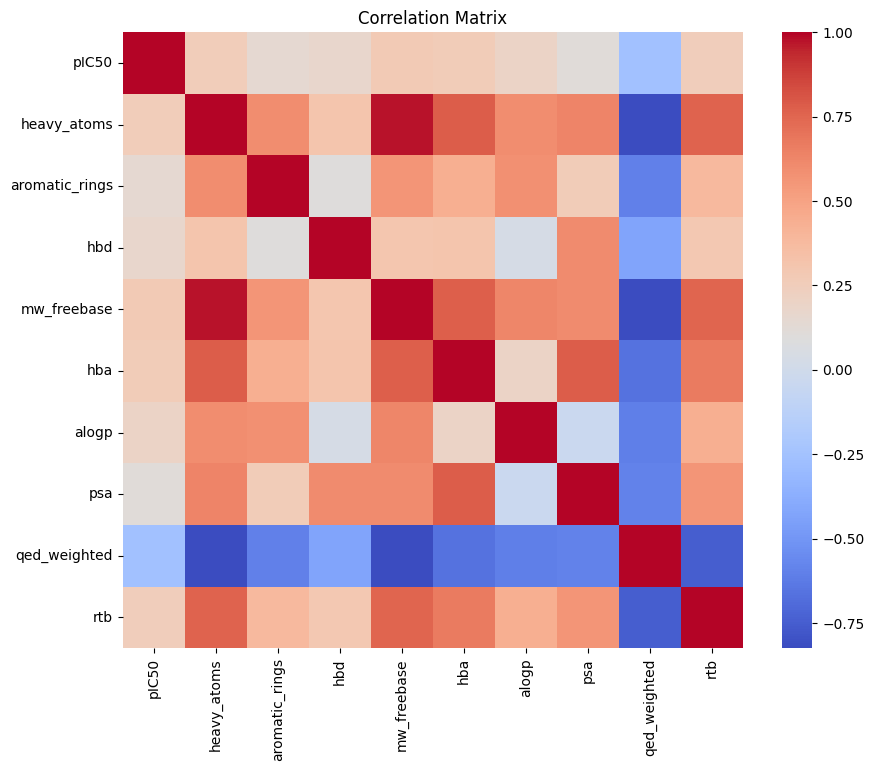

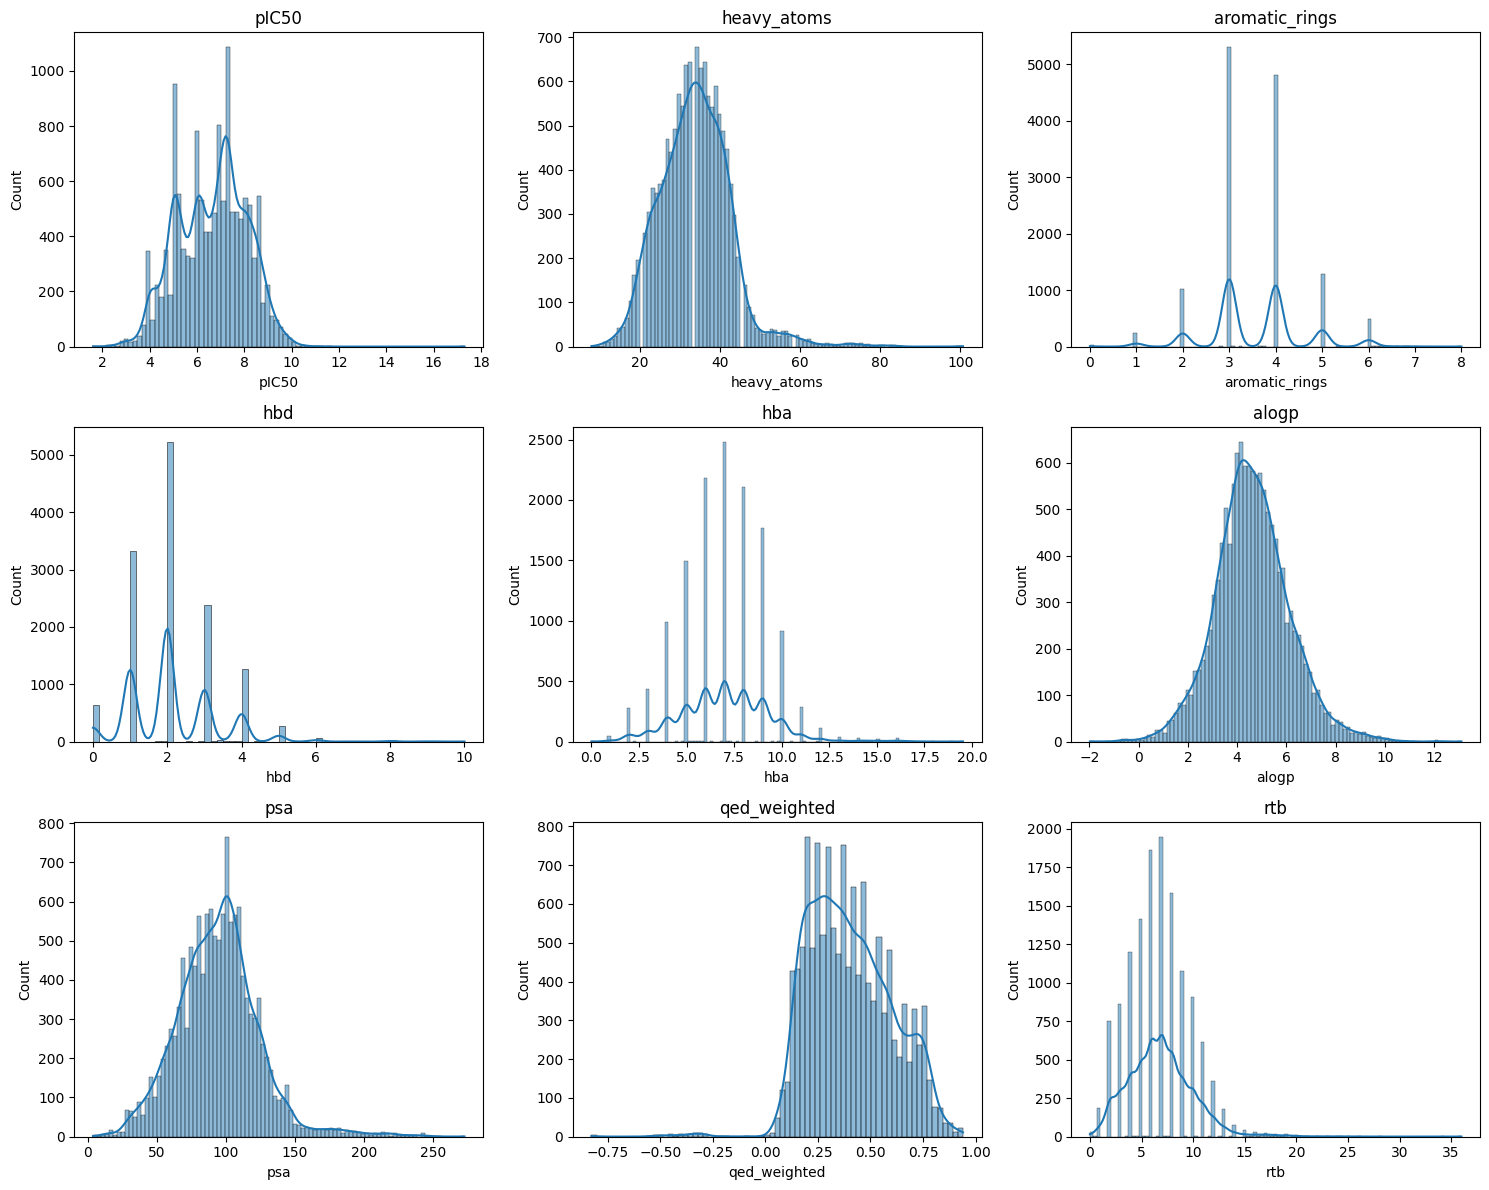

In [14]:
df = impute_iterative_sklearn(df)
df = analyze_correlation(df, threshold=0.9)
plot_all_distributions(df)

In [15]:
def analyze_outliers_iqr(df: pl.DataFrame, factor: float = 1.5) -> pl.DataFrame:
    """Calculates IQR statistics and outlier counts for numeric features."""
    numeric_cols = [c for c, t in zip(df.columns, df.dtypes) if t in [pl.Float64, pl.Int64]]
    report_data = []

    for col in numeric_cols:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        
        if q1 is None or q3 is None:
            continue
            
        iqr = q3 - q1
        lower_bound = q1 - (factor * iqr)
        upper_bound = q3 + (factor * iqr)
        
        outlier_count = df.filter(
            (pl.col(col) < lower_bound) | (pl.col(col) > upper_bound)
        ).height
        
        report_data.append({
            "Feature": col,
            "IQR": iqr,
            "Lower_Bound": lower_bound,
            "Upper_Bound": upper_bound,
            "Outliers": outlier_count,
            "Outliers_Pct": round((outlier_count / df.height) * 100, 2)
        })
        
    return pl.DataFrame(report_data).sort("Outliers_Pct", descending=True)

def plot_boxplots_grid(df: pl.DataFrame):
    """Generates a grid of boxplots for all numeric features."""
    numeric_cols = [c for c, t in zip(df.columns, df.dtypes) if t in [pl.Float64, pl.Int64]]
    if not numeric_cols:
        return

    n_plots = len(numeric_cols)
    n_cols = 3
    n_rows = math.ceil(n_plots / n_cols)
    
    # Convert to pandas once for visualization efficiency
    pdf = df.select(numeric_cols).to_pandas()
    
    plt.figure(figsize=(16, 4 * n_rows))
    for i, col in enumerate(numeric_cols):
        plt.subplot(n_rows, n_cols, i + 1)
        sns.boxplot(x=pdf[col], color="#4C72B0")
        plt.title(col, fontweight='bold')
        plt.xlabel("")
        
    plt.tight_layout()
    plt.show()

In [ ]:
# here we will begin to introduce dataset versioning
outlier_report = analyze_outliers_iqr(df)
print(outlier_report)

plot_boxplots_grid(df)

shape: (9, 6)
┌────────────────┬──────────┬─────────────┬─────────────┬──────────┬──────────────┐
│ Feature        ┆ IQR      ┆ Lower_Bound ┆ Upper_Bound ┆ Outliers ┆ Outliers_Pct │
│ ---            ┆ ---      ┆ ---         ┆ ---         ┆ ---      ┆ ---          │
│ str            ┆ f64      ┆ f64         ┆ f64         ┆ i64      ┆ f64          │
╞════════════════╪══════════╪═════════════╪═════════════╪══════════╪══════════════╡
│ aromatic_rings ┆ 1.0      ┆ 1.5         ┆ 5.5         ┆ 817      ┆ 6.15         │
│ hba            ┆ 2.0      ┆ 3.0         ┆ 11.0        ┆ 613      ┆ 4.61         │
│ psa            ┆ 34.38    ┆ 24.56       ┆ 162.08      ┆ 354      ┆ 2.66         │
│ alogp          ┆ 1.85     ┆ 0.905       ┆ 8.305       ┆ 299      ┆ 2.25         │
│ heavy_atoms    ┆ 11.0     ┆ 11.5        ┆ 55.5        ┆ 289      ┆ 2.18         │
│ rtb            ┆ 4.0      ┆ -1.0        ┆ 15.0        ┆ 164      ┆ 1.23         │
│ qed_weighted   ┆ 0.29     ┆ -0.185      ┆ 0.975       ┆ 62  

In [ ]:
"""
Analiza Przestrzeni Chemicznej (Chemical Space Analysis)

Analiza Korelacji Fizykochemicznych (X vs Y)

Analiza Różnorodności (Scaffold Analysis)
"""